In [1]:
# General imports
import numpy as np

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

In [2]:
# runtime imports
# from qiskit_ibm_runtime import QiskitRuntimeService, Session
# # To run on hardware, select the backend with the fewest number of jobs in the queue
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_aer import QasmSimulator, AerSimulator

backend = QasmSimulator()

In [14]:
# hamiltonian = SparsePauliOp.from_list(
#     [("YZ", 0.3980), ("ZI", -0.3980), ("ZZ", -0.0113), ("XX", 0.1810)]
# )

hamiltonian = SparsePauliOp.from_list(
    [("YZ", 0.3980)]
)

print(hamiltonian)

SparsePauliOp(['YZ'],
              coeffs=[0.398+0.j])


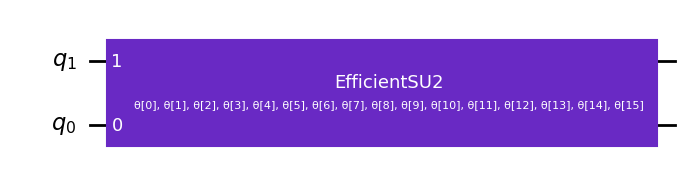

In [16]:
ansatz = EfficientSU2(hamiltonian.num_qubits)
ansatz.draw()

In [17]:
num_params = ansatz.num_parameters

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

ansatz_isa = pm.run(ansatz)

hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

In [18]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [19]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [20]:
x0 = 2 * np.pi * np.random.random(num_params)

In [21]:
with Session(backend=backend) as session:
    estimator = Estimator(session=session)
    estimator.options.default_shots = 10000

    res = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

/home/azhar04/.local/lib/python3.10/site-packages/qiskit_ibm_runtime/session.py:157: UserWarning: Session is not supported in local testing mode or when using a simulator.
  warnings.warn(
/home/azhar04/.local/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:243: UserWarning: Options {'default_shots': 10000} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Iters. done: 1 [Current cost: -0.15682910156250002]
Iters. done: 2 [Current cost: -0.12437500000000001]
Iters. done: 3 [Current cost: -0.16868359375]
Iters. done: 4 [Current cost: -0.147306640625]
Iters. done: 5 [Current cost: -0.154302734375]
Iters. done: 6 [Current cost: -0.0406162109375]


Iters. done: 7 [Current cost: -0.0188505859375]
Iters. done: 8 [Current cost: 0.0285673828125]
Iters. done: 9 [Current cost: -0.160521484375]
Iters. done: 10 [Current cost: -0.025069335937500003]
Iters. done: 11 [Current cost: 0.054025390625]
Iters. done: 12 [Current cost: -0.36301953125]
Iters. done: 13 [Current cost: -0.2625478515625]
Iters. done: 14 [Current cost: -0.10766210937500001]
Iters. done: 15 [Current cost: -0.22348632812500002]
Iters. done: 16 [Current cost: -0.3608818359375]
Iters. done: 17 [Current cost: -0.078123046875]
Iters. done: 18 [Current cost: -0.2042470703125]
Iters. done: 19 [Current cost: -0.35330273437500004]
Iters. done: 20 [Current cost: -0.38828320312500003]
Iters. done: 21 [Current cost: -0.361076171875]
Iters. done: 22 [Current cost: -0.3853681640625]
Iters. done: 23 [Current cost: -0.371958984375]
Iters. done: 24 [Current cost: -0.391392578125]
Iters. done: 25 [Current cost: -0.3715703125]
Iters. done: 26 [Current cost: -0.388671875]
Iters. done: 27 [Cu

In [22]:
print(res)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -0.3962509765625
       x: [ 2.719e+00  6.244e+00 ...  5.515e+00  4.159e+00]
    nfev: 156
   maxcv: 0.0


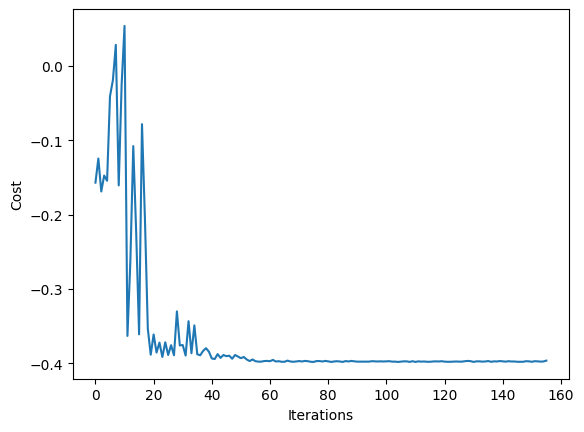

In [23]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()